In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mygrad import sliding_window_view

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Dropout, LSTM
import tensorflow as tf

%matplotlib notebook

Functions from POMS_sentiment used to load existing dictionary

In [3]:
def load_sent_dict(path="sent_dict.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_sent_dict(sent_dict, path="sent_dict.txt"):
    with open(path, "wb") as f:
        pickle.dump(sent_dict, f, pickle.HIGHEST_PROTOCOL)

def sentiment_time_series(sent_dict, key):
    N = max(sent_dict.keys())
    
    T = np.ndarray((N,))
    for i in range(N):
        T[i] = sent_dict[i][key]
        
    #convert to z-scores
    mean = np.mean(T)
    std  = np.std(T)
    T = (T - mean) / std
        
    return T

In [54]:
sent_dict = load_sent_dict(path="sent_dict_smooth.txt")

Functions from DJIA_preprocess used to load DJIA data

In [55]:
def load_djia(path="djia_ts.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_djia(ts, path="djia_ts.txt"):
    with open(path, "wb") as f:
        pickle.dump(ts, f, pickle.HIGHEST_PROTOCOL)

In [56]:
djia = load_djia(path="djia_ts.txt")

Load in relevant part of the DJIA data for training, zscore it, and create time series for Calm and Happy

In [57]:
train_djia = djia[130:130+98]
#train_djia = djia[:98]
train_djia = (train_djia - np.mean(train_djia)) / np.std(train_djia)

In [66]:
calm = -sentiment_time_series(sent_dict, "tension") - sentiment_time_series(sent_dict, "anger")
happy = sentiment_time_series(sent_dict, "vigour") - sentiment_time_series(sent_dict, "depression")
alert = -sentiment_time_series(sent_dict, "fatigue") - sentiment_time_series(sent_dict, "confusion")

dfft = np.fft.fft(calm)
dfft[20:] = 0
calm = np.real(np.fft.ifft(dfft))

dfft = np.fft.fft(happy)
dfft[20:] = 0
happy = np.real(np.fft.ifft(dfft))

dfft = np.fft.fft(alert)
dfft[20:] = 0
alert = np.real(np.fft.ifft(dfft))

This function creates a dataset by looking at "windows" of previous time series values. In other words, we're trying to predict a stock value on each day by looking at sentiment data in the past $N$ days. Obviously this means we can't do predictions for the first $N$ days which makes sense.

Experiment: to augment time series data with previous returns, you could attempt to pass DJIA data to this function as well as other time series.

We can then easily generate our training data using a call of this function.

In [67]:
def windowed_data(window_size, *ts_data):
    k = window_size * len(ts_data)
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, k))
    
    for i, ts in enumerate(ts_data):
        dataset[:,window_size*i:window_size*(i+1)] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset[:-1]

In [68]:
N = 3
x_train = windowed_data(N+1, calm, happy, alert)
y_train = train_djia[N:-1]
x_train.shape, y_train.shape

((94, 12), (94,))

This function will test any of our prediction algorithms by a simple cross validation.

In [69]:
def cross_validate_model(k, x_data, y_data, model):
    size = int(len(x_data) / k)
    
    prediction = np.zeros(y_data.shape)
        
    for i in range(k):
        
        if i == k-1:
            x_train = x_data[:i*size]
            y_train = y_data[:i*size]

            x_test = x_data[i*size:]
            y_test = y_data[i*size:]
            
            prediction[i*size:] = model(x_test, x_train, y_train)
        else:
            x_train = np.concatenate((x_data[:i*size], x_data[(i+1)*size:]))
            y_train = np.concatenate((y_data[:i*size], y_data[(i+1)*size:]))

            x_test = x_data[i*size:(i+1)*size]
            y_test = y_data[i*size:(i+1)*size]
        
            prediction[i*size:(i+1)*size] = model(x_test, x_train, y_train)
            
        print("Fold " + str(i) + " trained.")
        
    return prediction

def mape(truth, prediction):
    #return np.abs(truth - prediction)
    return np.mean(np.abs((truth - prediction) / truth))

def rmse(truth, prediction):
    return np.sqrt(np.mean((truth - prediction) ** 2))

def accuracy(truth, prediction, lag):
    length = len(truth)
    correct = 0.0
    for i in range(lag,length):
        lastTruth = np.mean(truth[i-lag:i])
        lastPred  = np.mean(prediction[i-lag:i])
        if (truth[i] >= lastTruth and prediction[i] >= lastPred):
            correct += 1
        elif (truth[i] <= lastTruth and prediction[i] <= lastPred):
            correct += 1
    
    return correct / (length - lag)

Our first (very simple) prediction algorithm: linear regression

In [70]:
def linreg_prediction(A, x_train, y_train):
    factor = np.linalg.lstsq(x_train, y_train, rcond=None)[0]
    return np.matmul(A, factor)

<IPython.core.display.Javascript object>


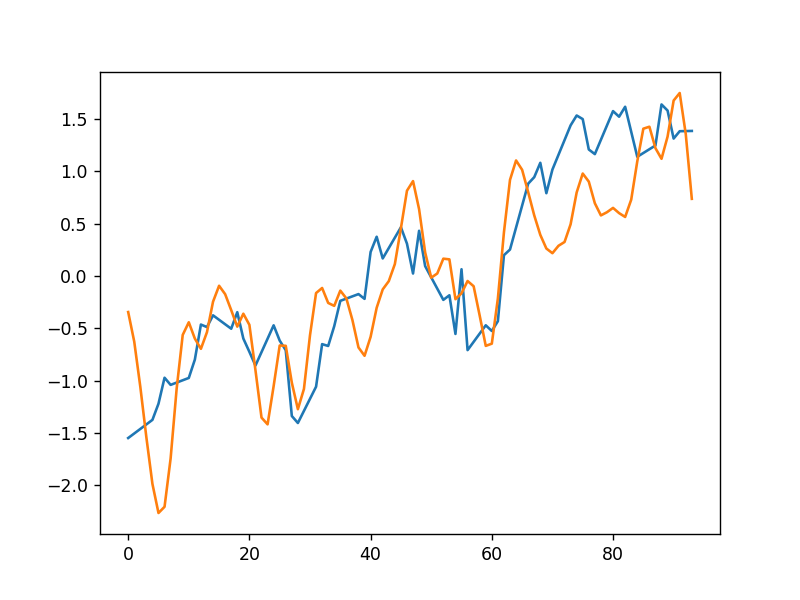

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


In [71]:
fig, ax = plt.subplots()
ax.plot(y_train)
ax.plot(cross_validate_model(5, x_train, y_train, linreg_prediction))

In [75]:
linear_output = cross_validate_model(5, x_train, y_train, linreg_prediction)
rmse(y_train, linear_output), accuracy(y_train, linear_output, 1)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


(0.5292748109036649, 0.4946236559139785)

Model for a dense neural network with 3 sigmoid layers.

In [76]:
model = Sequential()
model.add(Dense(128, input_shape=((1+N)*3,), activation="sigmoid"))
model.add(Dense(32, activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [77]:
history = model.fit(x_train, y_train, epochs=300, batch_size=20, verbose=1, validation_split=0.2)

Train on 75 samples, validate on 19 samples
Epoch 1/300
75/75 [==============================] - 1s 18ms/step - loss: 1.3814 - mean_squared_error: 1.3814 - mean_absolute_error: 0.9652 - val_loss: 1.6219 - val_mean_squared_error: 1.6219 - val_mean_absolute_error: 1.2641
Epoch 2/300
75/75 [==============================] - 0s 359us/step - loss: 1.1176 - mean_squared_error: 1.1176 - mean_absolute_error: 0.8621 - val_loss: 2.0193 - val_mean_squared_error: 2.0193 - val_mean_absolute_error: 1.4125
Epoch 3/300
75/75 [==============================] - 0s 372us/step - loss: 1.3184 - mean_squared_error: 1.3184 - mean_absolute_error: 0.9278 - val_loss: 2.3438 - val_mean_squared_error: 2.3438 - val_mean_absolute_error: 1.5230
Epoch 4/300
75/75 [==============================] - 0s 425us/step - loss: 1.0888 - mean_squared_error: 1.0888 - mean_absolute_error: 0.8659 - val_loss: 2.6174 - val_mean_squared_error: 2.6174 - val_mean_absolute_error: 1.6102
Epoch 5/300
75/75 [==============================

Epoch 37/300
75/75 [==============================] - 0s 346us/step - loss: 0.6247 - mean_squared_error: 0.6247 - mean_absolute_error: 0.6440 - val_loss: 2.4589 - val_mean_squared_error: 2.4589 - val_mean_absolute_error: 1.5595
Epoch 38/300
75/75 [==============================] - 0s 306us/step - loss: 0.6435 - mean_squared_error: 0.6435 - mean_absolute_error: 0.6403 - val_loss: 2.4482 - val_mean_squared_error: 2.4482 - val_mean_absolute_error: 1.5561
Epoch 39/300
75/75 [==============================] - 0s 386us/step - loss: 0.6121 - mean_squared_error: 0.6121 - mean_absolute_error: 0.6416 - val_loss: 2.4470 - val_mean_squared_error: 2.4470 - val_mean_absolute_error: 1.5557
Epoch 40/300
75/75 [==============================] - 0s 399us/step - loss: 0.6413 - mean_squared_error: 0.6413 - mean_absolute_error: 0.6301 - val_loss: 2.4412 - val_mean_squared_error: 2.4412 - val_mean_absolute_error: 1.5538
Epoch 41/300
75/75 [==============================] - 0s 346us/step - loss: 0.5518 - mea

Epoch 108/300
75/75 [==============================] - 0s 372us/step - loss: 0.2985 - mean_squared_error: 0.2985 - mean_absolute_error: 0.4355 - val_loss: 1.2558 - val_mean_squared_error: 1.2558 - val_mean_absolute_error: 1.0990
Epoch 109/300
75/75 [==============================] - 0s 439us/step - loss: 0.3219 - mean_squared_error: 0.3219 - mean_absolute_error: 0.4366 - val_loss: 1.2394 - val_mean_squared_error: 1.2394 - val_mean_absolute_error: 1.0913
Epoch 110/300
75/75 [==============================] - 0s 665us/step - loss: 0.3032 - mean_squared_error: 0.3032 - mean_absolute_error: 0.4578 - val_loss: 1.2173 - val_mean_squared_error: 1.2173 - val_mean_absolute_error: 1.0810
Epoch 111/300
75/75 [==============================] - 0s 479us/step - loss: 0.3320 - mean_squared_error: 0.3320 - mean_absolute_error: 0.4765 - val_loss: 1.2035 - val_mean_squared_error: 1.2035 - val_mean_absolute_error: 1.0743
Epoch 112/300
75/75 [==============================] - 0s 386us/step - loss: 0.3132 

Epoch 144/300
75/75 [==============================] - 0s 426us/step - loss: 0.3250 - mean_squared_error: 0.3250 - mean_absolute_error: 0.4443 - val_loss: 0.8733 - val_mean_squared_error: 0.8733 - val_mean_absolute_error: 0.9023
Epoch 145/300
75/75 [==============================] - 0s 439us/step - loss: 0.3486 - mean_squared_error: 0.3486 - mean_absolute_error: 0.4707 - val_loss: 0.8782 - val_mean_squared_error: 0.8782 - val_mean_absolute_error: 0.9050
Epoch 146/300
75/75 [==============================] - 0s 372us/step - loss: 0.2518 - mean_squared_error: 0.2518 - mean_absolute_error: 0.4077 - val_loss: 0.8881 - val_mean_squared_error: 0.8881 - val_mean_absolute_error: 0.9106
Epoch 147/300
75/75 [==============================] - 0s 439us/step - loss: 0.3016 - mean_squared_error: 0.3016 - mean_absolute_error: 0.4480 - val_loss: 0.9003 - val_mean_squared_error: 0.9003 - val_mean_absolute_error: 0.9168
Epoch 148/300
75/75 [==============================] - 0s 346us/step - loss: 0.2736 

Epoch 180/300
75/75 [==============================] - 0s 399us/step - loss: 0.2439 - mean_squared_error: 0.2439 - mean_absolute_error: 0.3992 - val_loss: 0.8011 - val_mean_squared_error: 0.8011 - val_mean_absolute_error: 0.8575
Epoch 181/300
75/75 [==============================] - 0s 399us/step - loss: 0.3083 - mean_squared_error: 0.3083 - mean_absolute_error: 0.4304 - val_loss: 0.8045 - val_mean_squared_error: 0.8045 - val_mean_absolute_error: 0.8596
Epoch 182/300
75/75 [==============================] - 0s 372us/step - loss: 0.3179 - mean_squared_error: 0.3179 - mean_absolute_error: 0.4397 - val_loss: 0.8044 - val_mean_squared_error: 0.8044 - val_mean_absolute_error: 0.8600
Epoch 183/300
75/75 [==============================] - 0s 319us/step - loss: 0.2025 - mean_squared_error: 0.2025 - mean_absolute_error: 0.3623 - val_loss: 0.7941 - val_mean_squared_error: 0.7941 - val_mean_absolute_error: 0.8546
Epoch 184/300
75/75 [==============================] - 0s 426us/step - loss: 0.2693 

Epoch 216/300
75/75 [==============================] - 0s 319us/step - loss: 0.2309 - mean_squared_error: 0.2309 - mean_absolute_error: 0.3931 - val_loss: 0.7257 - val_mean_squared_error: 0.7257 - val_mean_absolute_error: 0.8127
Epoch 217/300
75/75 [==============================] - 0s 386us/step - loss: 0.2037 - mean_squared_error: 0.2037 - mean_absolute_error: 0.3612 - val_loss: 0.7318 - val_mean_squared_error: 0.7318 - val_mean_absolute_error: 0.8159
Epoch 218/300
75/75 [==============================] - 0s 386us/step - loss: 0.2267 - mean_squared_error: 0.2267 - mean_absolute_error: 0.3889 - val_loss: 0.7220 - val_mean_squared_error: 0.7220 - val_mean_absolute_error: 0.8101
Epoch 219/300
75/75 [==============================] - 0s 439us/step - loss: 0.2380 - mean_squared_error: 0.2380 - mean_absolute_error: 0.3955 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - val_mean_absolute_error: 0.8130
Epoch 220/300
75/75 [==============================] - 0s 399us/step - loss: 0.2745 

Epoch 252/300
75/75 [==============================] - 0s 426us/step - loss: 0.2269 - mean_squared_error: 0.2269 - mean_absolute_error: 0.3705 - val_loss: 0.6907 - val_mean_squared_error: 0.6907 - val_mean_absolute_error: 0.7933
Epoch 253/300
75/75 [==============================] - 0s 439us/step - loss: 0.2063 - mean_squared_error: 0.2063 - mean_absolute_error: 0.3613 - val_loss: 0.6893 - val_mean_squared_error: 0.6893 - val_mean_absolute_error: 0.7926
Epoch 254/300
75/75 [==============================] - 0s 412us/step - loss: 0.2782 - mean_squared_error: 0.2782 - mean_absolute_error: 0.4247 - val_loss: 0.6915 - val_mean_squared_error: 0.6915 - val_mean_absolute_error: 0.7939
Epoch 255/300
75/75 [==============================] - 0s 359us/step - loss: 0.1931 - mean_squared_error: 0.1931 - mean_absolute_error: 0.3594 - val_loss: 0.6948 - val_mean_squared_error: 0.6948 - val_mean_absolute_error: 0.7958
Epoch 256/300
75/75 [==============================] - 0s 359us/step - loss: 0.2420 

Epoch 288/300
75/75 [==============================] - 0s 412us/step - loss: 0.2320 - mean_squared_error: 0.2320 - mean_absolute_error: 0.4011 - val_loss: 0.6024 - val_mean_squared_error: 0.6024 - val_mean_absolute_error: 0.7375
Epoch 289/300
75/75 [==============================] - 0s 346us/step - loss: 0.2176 - mean_squared_error: 0.2176 - mean_absolute_error: 0.3708 - val_loss: 0.5969 - val_mean_squared_error: 0.5969 - val_mean_absolute_error: 0.7335
Epoch 290/300
75/75 [==============================] - 0s 386us/step - loss: 0.2377 - mean_squared_error: 0.2377 - mean_absolute_error: 0.3739 - val_loss: 0.6111 - val_mean_squared_error: 0.6111 - val_mean_absolute_error: 0.7418
Epoch 291/300
75/75 [==============================] - 0s 372us/step - loss: 0.2128 - mean_squared_error: 0.2128 - mean_absolute_error: 0.3730 - val_loss: 0.6278 - val_mean_squared_error: 0.6278 - val_mean_absolute_error: 0.7519
Epoch 292/300
75/75 [==============================] - 0s 492us/step - loss: 0.2242 

<IPython.core.display.Javascript object>


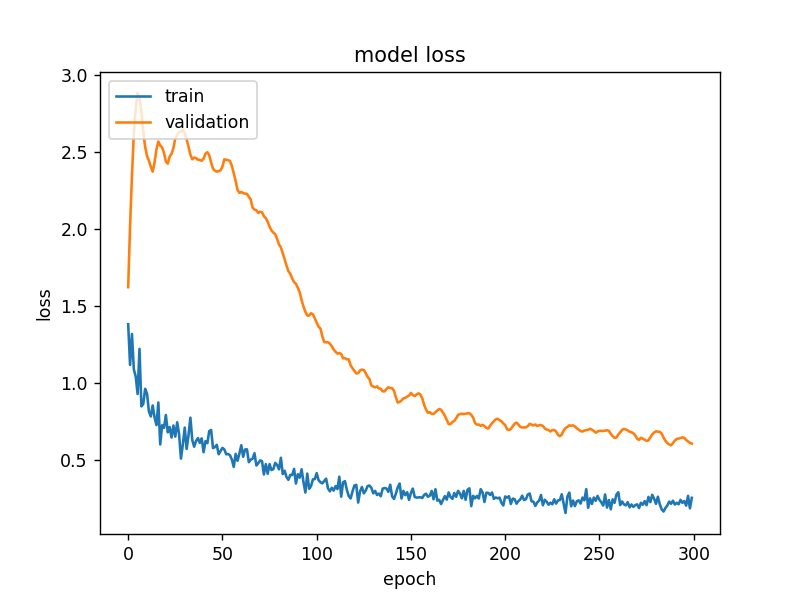

In [78]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [140]:
def dense_prediction(A, x_train, y_train):
    model = Sequential()
    model.add(Dense(512, input_shape=(3*(N+1),), activation="sigmoid"))
    model.add(Dense(512, activation="sigmoid"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='adagrad', metrics=['mse', 'mae'])
    model.fit(x_train, y_train, epochs=300, batch_size=10, verbose=0)
    
    return model.predict(A).flatten()

In [141]:
dense_output = cross_validate_model(5, x_train, y_train, dense_prediction)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


<IPython.core.display.Javascript object>


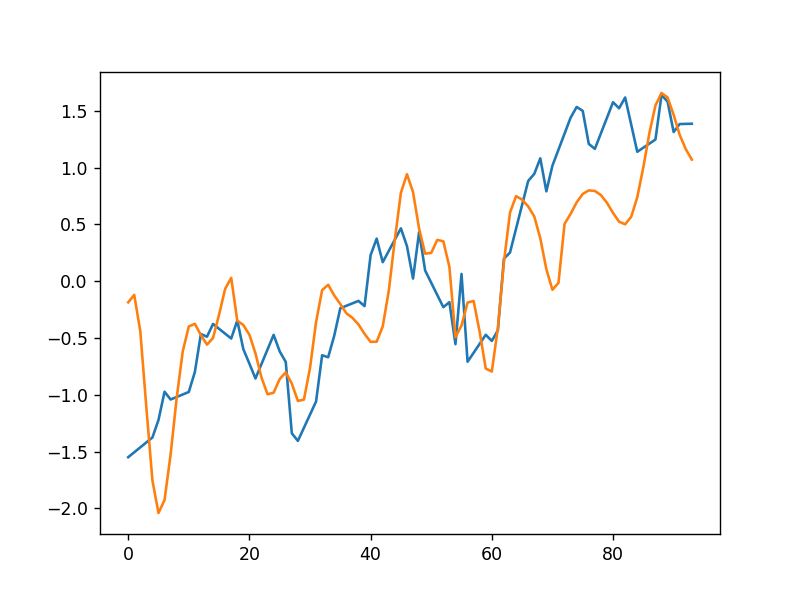

In [142]:
fig, ax = plt.subplots()
ax.plot(y_train)

ax.plot(dense_output)
#ax.plot(np.random.rand(94))

In [145]:
rmse(y_train, dense_output), accuracy(y_train, dense_output, 1)

(0.5384993276202852, 0.5053763440860215)

Finally, we'll use a *recurrent* neural network for our last type of model. In particular we'll use a long-short term memory network or LSTM with 256 filters. This requires a slightly different windowed data function, but trains in much the same way as the dense network.

In [153]:
def windowed_data_lstm(window_size, *ts_data):
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, window_size, len(ts_data)))
    
    for i, ts in enumerate(ts_data):
        dataset[:,:,i] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset

In [200]:
x_train_lstm = windowed_data_lstm(3, calm, happy, alert)
y_train_lstm = train_djia[2:]

In [183]:
model = Sequential()
model.add(LSTM(256, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae'])

In [184]:
history = model.fit(x_train_lstm, y_train, epochs=500, batch_size=5, verbose=1, validation_split=0.2)

Train on 75 samples, validate on 19 samples
Epoch 1/500
75/75 [==============================] - 4s 60ms/step - loss: 0.4056 - mean_squared_error: 0.4056 - mean_absolute_error: 0.4933 - val_loss: 1.4271 - val_mean_squared_error: 1.4271 - val_mean_absolute_error: 1.1643
Epoch 2/500
75/75 [==============================] - 0s 6ms/step - loss: 0.2529 - mean_squared_error: 0.2529 - mean_absolute_error: 0.3981 - val_loss: 0.9529 - val_mean_squared_error: 0.9529 - val_mean_absolute_error: 0.8905
Epoch 3/500
75/75 [==============================] - 1s 8ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - mean_absolute_error: 0.3762 - val_loss: 0.4548 - val_mean_squared_error: 0.4548 - val_mean_absolute_error: 0.5747
Epoch 4/500
75/75 [==============================] - 1s 9ms/step - loss: 0.1999 - mean_squared_error: 0.1999 - mean_absolute_error: 0.3716 - val_loss: 0.5493 - val_mean_squared_error: 0.5493 - val_mean_absolute_error: 0.6228
Epoch 5/500
75/75 [==============================] - 1s

75/75 [==============================] - 0s 4ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1061 - val_loss: 0.4059 - val_mean_squared_error: 0.4059 - val_mean_absolute_error: 0.5515
Epoch 74/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0956 - val_loss: 0.5951 - val_mean_squared_error: 0.5951 - val_mean_absolute_error: 0.6659
Epoch 75/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0998 - val_loss: 0.8067 - val_mean_squared_error: 0.8067 - val_mean_absolute_error: 0.7780
Epoch 76/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0971 - val_loss: 0.9654 - val_mean_squared_error: 0.9654 - val_mean_absolute_error: 0.8040
Epoch 77/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0171 - mean_squared_error: 0.0171

Epoch 145/500
75/75 [==============================] - 1s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0703 - val_loss: 0.5203 - val_mean_squared_error: 0.5203 - val_mean_absolute_error: 0.5936
Epoch 146/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0588 - val_loss: 0.4411 - val_mean_squared_error: 0.4411 - val_mean_absolute_error: 0.5652
Epoch 147/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0627 - val_loss: 0.5998 - val_mean_squared_error: 0.5998 - val_mean_absolute_error: 0.6540
Epoch 148/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0493 - val_loss: 0.3223 - val_mean_squared_error: 0.3223 - val_mean_absolute_error: 0.4686
Epoch 149/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0058 - mean_squ

75/75 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0593 - val_loss: 0.4714 - val_mean_squared_error: 0.4714 - val_mean_absolute_error: 0.5922
Epoch 218/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0431 - val_loss: 0.5182 - val_mean_squared_error: 0.5182 - val_mean_absolute_error: 0.6095
Epoch 219/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.5866 - val_mean_squared_error: 0.5866 - val_mean_absolute_error: 0.6503
Epoch 220/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0463 - val_loss: 0.5764 - val_mean_squared_error: 0.5764 - val_mean_absolute_error: 0.6594
Epoch 221/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0040 - mean_squared_error: 0.

Epoch 253/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0443 - val_loss: 0.4972 - val_mean_squared_error: 0.4972 - val_mean_absolute_error: 0.6103
Epoch 254/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0404 - val_loss: 0.4284 - val_mean_squared_error: 0.4284 - val_mean_absolute_error: 0.5763
Epoch 255/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0390 - val_loss: 0.3910 - val_mean_squared_error: 0.3910 - val_mean_absolute_error: 0.5311
Epoch 256/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0560 - val_loss: 0.4334 - val_mean_squared_error: 0.4334 - val_mean_absolute_error: 0.5766
Epoch 257/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0023 - mean_squ

75/75 [==============================] - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.4229 - val_mean_squared_error: 0.4229 - val_mean_absolute_error: 0.5679
Epoch 326/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0385 - val_loss: 0.5684 - val_mean_squared_error: 0.5684 - val_mean_absolute_error: 0.6550
Epoch 327/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0456 - val_loss: 0.5738 - val_mean_squared_error: 0.5738 - val_mean_absolute_error: 0.6592
Epoch 328/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0316 - val_loss: 0.4875 - val_mean_squared_error: 0.4875 - val_mean_absolute_error: 0.6064
Epoch 329/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0288 - val_loss: 0.4739 - val_mean_squared_error: 0.4739 - val_mean_absolute_error: 0.5981
Epoch 398/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0283 - val_loss: 0.6662 - val_mean_squared_error: 0.6662 - val_mean_absolute_error: 0.6936
Epoch 399/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0356 - val_loss: 0.5765 - val_mean_squared_error: 0.5765 - val_mean_absolute_error: 0.6595
Epoch 400/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0305 - val_loss: 0.4341 - val_mean_squared_error: 0.4341 - val_mean_absolute_error: 0.5670
Epoch 401/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0332 - val_loss: 0.4688 - val_mean_squared_error: 0.4688 - val_mean_absolute_error: 0.5932
Epoch 434/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0245 - val_loss: 0.4551 - val_mean_squared_error: 0.4551 - val_mean_absolute_error: 0.5885
Epoch 435/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0272 - val_loss: 0.4495 - val_mean_squared_error: 0.4495 - val_mean_absolute_error: 0.5789
Epoch 436/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0338 - val_loss: 0.4247 - val_mean_squared_error: 0.4247 - val_mean_absolute_error: 0.5554
Epoch 437/500
75/75 [==============================] - 0s 4ms/step - loss: 8.3776e-04 - mean_squared_error

Epoch 469/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0284 - val_loss: 0.4305 - val_mean_squared_error: 0.4305 - val_mean_absolute_error: 0.5724
Epoch 470/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0257 - val_loss: 0.5113 - val_mean_squared_error: 0.5113 - val_mean_absolute_error: 0.6088
Epoch 471/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0264 - val_loss: 0.5212 - val_mean_squared_error: 0.5212 - val_mean_absolute_error: 0.6229
Epoch 472/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0263 - val_loss: 0.4788 - val_mean_squared_error: 0.4788 - val_mean_absolute_error: 0.5949
Epoch 473/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0010 - mean_squ

The training for an LSTM is more volatile than for the dense network on this small dataset, as shown below.

<IPython.core.display.Javascript object>


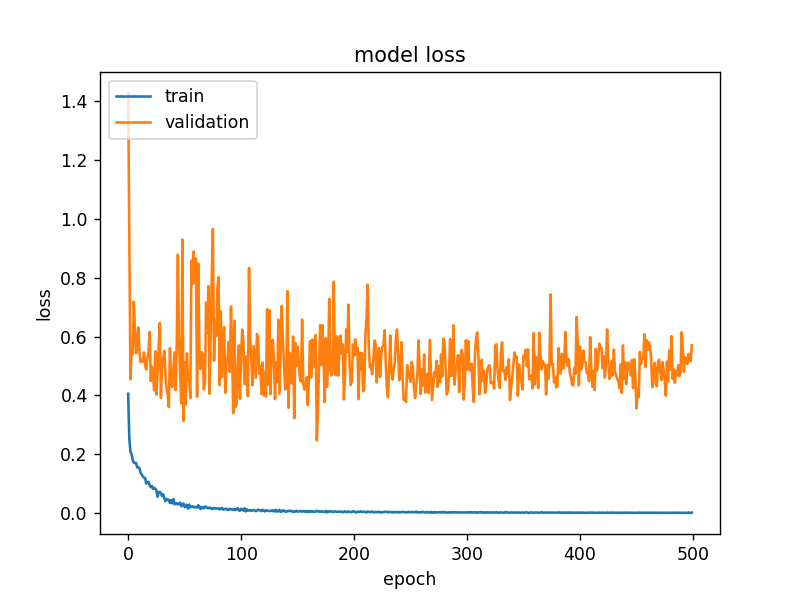

In [185]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [218]:
def lstm_prediction(A, x_train, y_train):
    model = Sequential()
    model.add(LSTM(256, activation="sigmoid"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae'])

    model.fit(x_train, y_train, epochs=300, batch_size=10, verbose=0)
    
    return model.predict(A).flatten()

In [219]:
lstm_output = cross_validate_model(5, x_train_lstm, y_train_lstm, lstm_prediction)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


The LSTM obtains a better accuracy score compared to the dense network and linear regression despite higher mean error. Thus, the LSTM is most likely the best model to use.

<IPython.core.display.Javascript object>


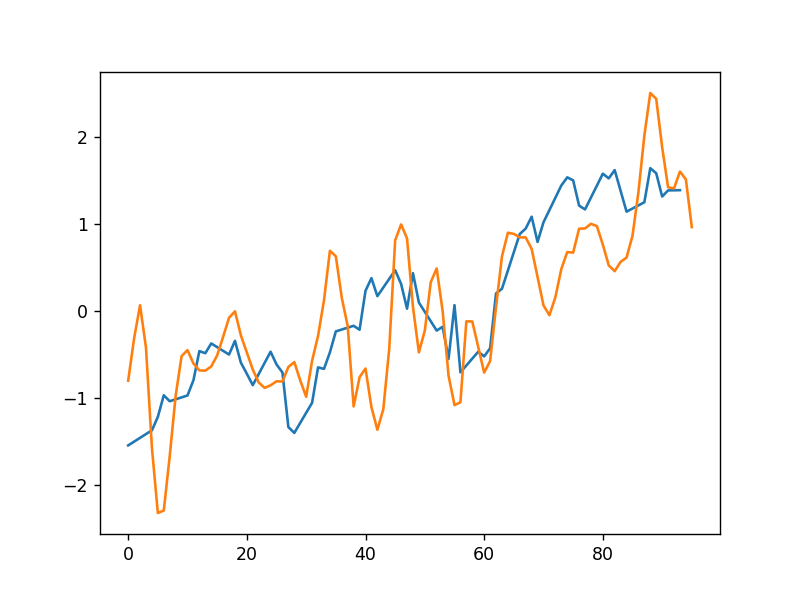

In [220]:
fig, ax = plt.subplots()
ax.plot(y_train)

ax.plot(lstm_output)